In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
!pip install -q mlflow nlp 2>/dev/null

# Importing All The Necessary Libraries

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    confusion_matrix, 
    classification_report, 
    f1_score
)

import gc
import re
import torch
from transformers import AutoModel, AutoTokenizer
from transformers import TextDataset, LineByLineTextDataset, DataCollatorForLanguageModeling, \
pipeline, Trainer, TrainingArguments, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from nlp import Dataset
from imblearn.over_sampling import RandomOverSampler
import datasets
from transformers import pipeline
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
Submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [7]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Explorartory Data Analysis 

## Class Distribution

In [8]:
Real_len = train_df[train_df['target'] == 1].shape[0]
Not_len = train_df[train_df['target'] == 0].shape[0]

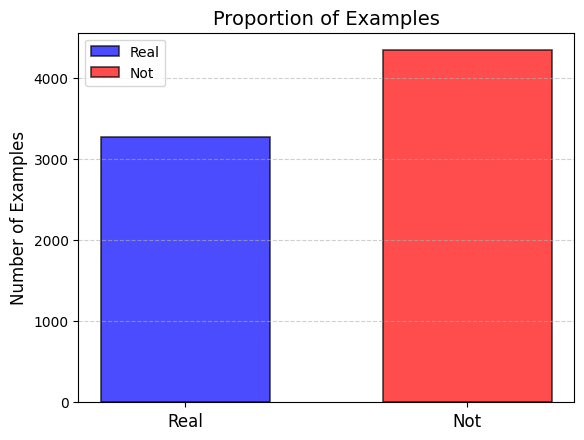

In [9]:
plt.bar(10, Real_len, 3, label="Real", color='blue', alpha=0.7, edgecolor='black', linewidth=1.2)
plt.bar(15, Not_len, 3, label="Not", color='red', alpha=0.7, edgecolor='black', linewidth=1.2)
plt.legend()
plt.ylabel('Number of Examples', fontsize=12)
plt.title('Proportion of Examples', fontsize=14)
plt.xticks([10, 15], ['Real', 'Not'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Numbers of Characters in tweets

In [10]:
def length(text):
    return len(text)

In [11]:
train_df["length"] = train_df["text"].apply(length)

## Distribution of Tweet Lengths (Real vs. Not)

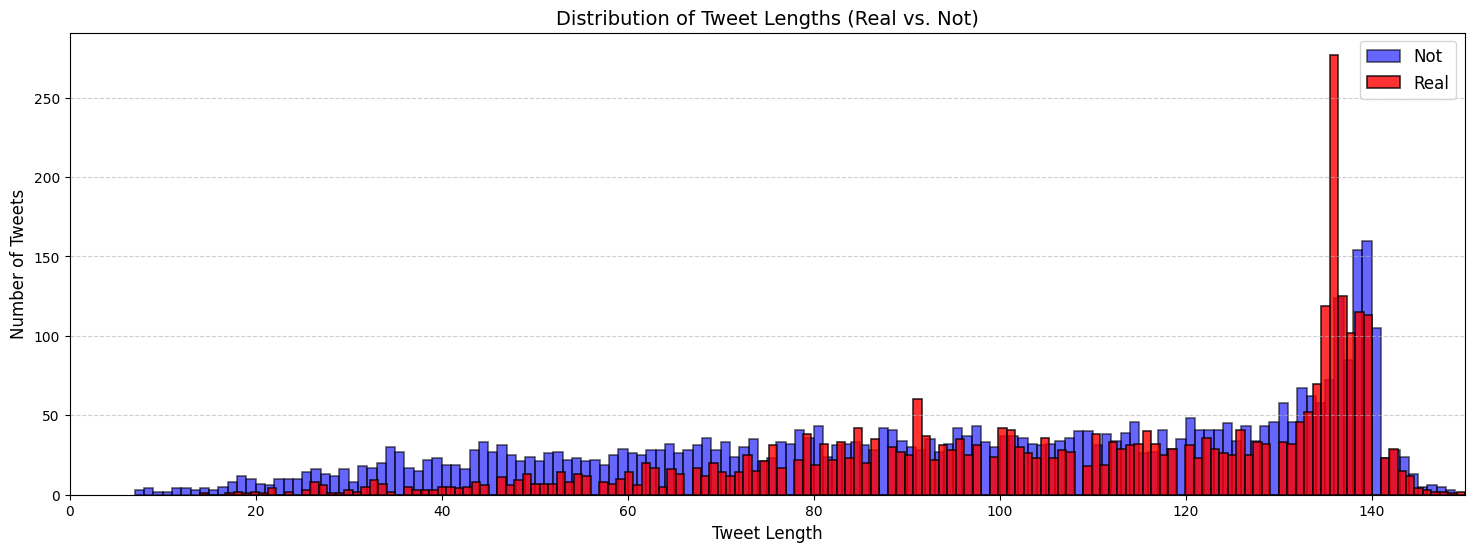

In [12]:
# Set the figure size
plt.rcParams['figure.figsize'] = (18.0, 6.0)

# Data and parameters
bins = 150
alpha_not = 0.6
alpha_real = 0.8
xlim_max = 150

# Plot histograms
plt.hist(train_df[train_df['target'] == 0]['length'], alpha=alpha_not, bins=bins, label='Not', color='blue', edgecolor='black', linewidth=1.2)
plt.hist(train_df[train_df['target'] == 1]['length'], alpha=alpha_real, bins=bins, label='Real', color='red', edgecolor='black', linewidth=1.2)

# Add labels and legend
plt.xlabel('Tweet Length', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.legend(loc='upper right', fontsize=12)

# Set the x-axis limit
plt.xlim(0, xlim_max)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Title
plt.title('Distribution of Tweet Lengths (Real vs. Not)', fontsize=14)

# Show the plot
plt.show()


## Character Count Distribution in Tweets

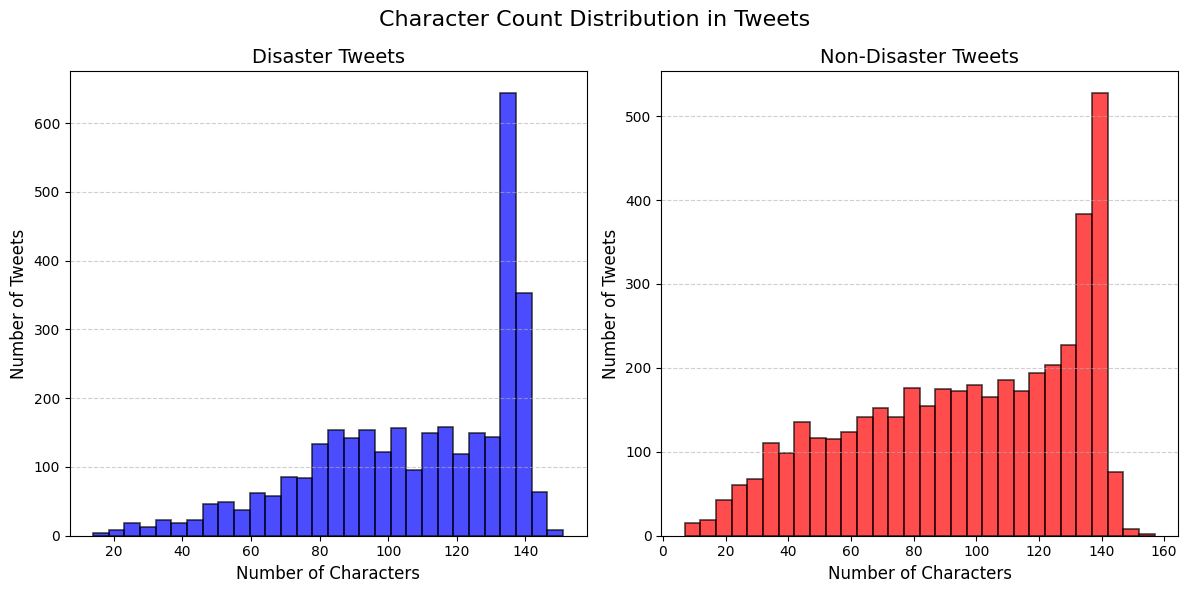

In [13]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Data
tweet_len_real = train_df[train_df['target'] == 1]['text'].str.len()
tweet_len_not = train_df[train_df['target'] == 0]['text'].str.len()

# Plot for disaster tweets
ax1.hist(tweet_len_real, bins=30, color='blue', alpha=0.7, edgecolor='black', linewidth=1.2)
ax1.set_title('Disaster Tweets', fontsize=14)
ax1.set_xlabel('Number of Characters', fontsize=12)
ax1.set_ylabel('Number of Tweets', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# Plot for non-disaster tweets
ax2.hist(tweet_len_not, bins=30, color='red', alpha=0.7, edgecolor='black', linewidth=1.2)
ax2.set_title('Non-Disaster Tweets', fontsize=14)
ax2.set_xlabel('Number of Characters', fontsize=12)
ax2.set_ylabel('Number of Tweets', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.6)

# Add a title to the overall figure
fig.suptitle('Character Count Distribution in Tweets', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Number of words in a tweet

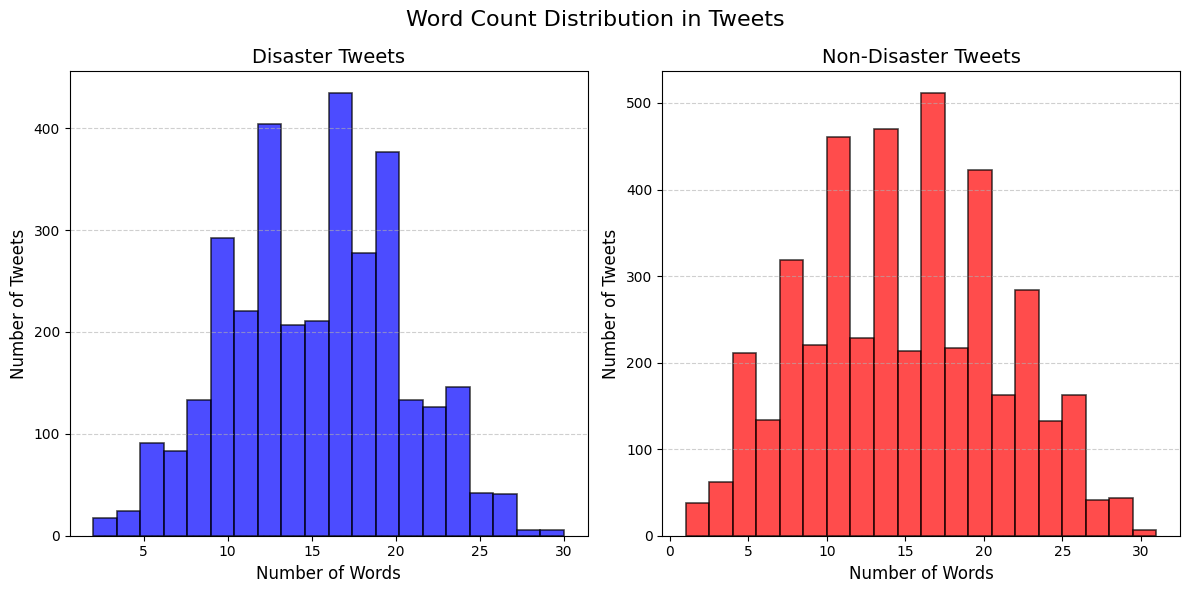

In [14]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Data
tweet_len_real = train_df[train_df['target'] == 1]['text'].str.split().map(lambda x: len(x))
tweet_len_not = train_df[train_df['target'] == 0]['text'].str.split().map(lambda x: len(x))

# Plot for disaster tweets
ax1.hist(tweet_len_real, bins=20, color='blue', alpha=0.7, edgecolor='black', linewidth=1.2)
ax1.set_title('Disaster Tweets', fontsize=14)
ax1.set_xlabel('Number of Words', fontsize=12)
ax1.set_ylabel('Number of Tweets', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# Plot for non-disaster tweets
ax2.hist(tweet_len_not, bins=20, color='red', alpha=0.7, edgecolor='black', linewidth=1.2)
ax2.set_title('Non-Disaster Tweets', fontsize=14)
ax2.set_xlabel('Number of Words', fontsize=12)
ax2.set_ylabel('Number of Tweets', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.6)

# Add a title to the overall figure
fig.suptitle('Word Count Distribution in Tweets', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Average word length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

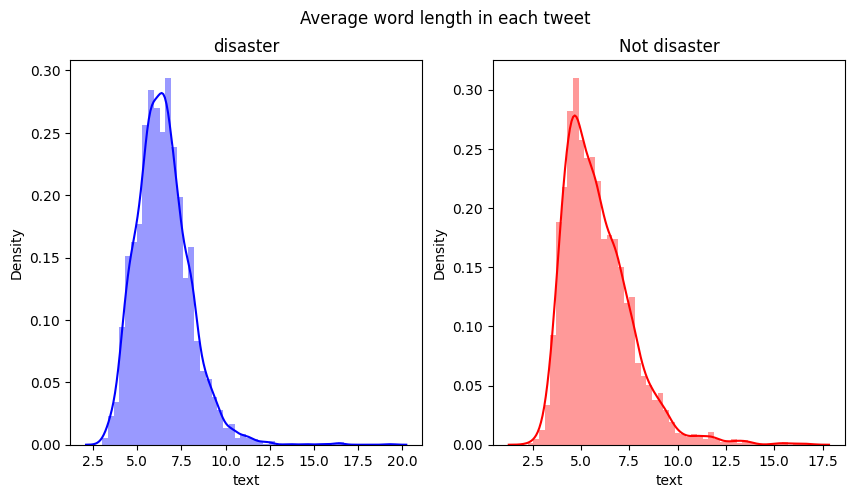

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train_df[train_df['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('disaster')
word=train_df[train_df['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [16]:
train_fraction = 0.8
num_train_epochs = 20
batch_size = 32
warmup_steps = 50
weight_decay = 0.01
learning_rate = 2e-6
num_titles = None 
BERT_MODEL = "distilbert-base-cased"
selected_cols = ['text', 'label']

In [17]:
def clean_text(rawtext):
    # Use BeautifulSoup to remove any HTML tags from the raw text
    cleantext = BeautifulSoup(rawtext, "lxml").text
    
    # Replace special characters '\u200a' and '\xa0' with spaces for better readability
    cleantext = cleantext.replace('\u200a', '').replace('\xa0', ' ')
    
    return cleantext

In [18]:
df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

df['text'] = df['text'].apply(clean_text)
df['label'] = df['target']

df = df[selected_cols].drop_duplicates()

# Randomly shuffle the rows in the dataframe to ensure randomness in the data
df = df.sample(frac=1)

print(df.shape)

# T for transposing
df.sample(5).T

(7521, 2)


,4533,2083,1524,1791,6920
text,Terrorists attack police post; 2 SPOs injured ...,#AskCharley #Emmerdale How emotional are you t...,Pretty much every time the audio dies on an au...,Make man pikin crash ??????,@JusstdoitGirl never said it was a problem and...
label,1,0,0,1,0


In [19]:
mean_target = df['label'].mean()
print(mean_target)

0.4262731019811195


In [20]:
y = df[['label']]

df = df.drop(['label'], axis=1)

# Create a RandomOverSampler object with a specified random seed (random_state=83)
ros = RandomOverSampler(random_state=83)

df, y_resampled = ros.fit_resample(df, y)

del y

df['label'] = y_resampled

del y_resampled

gc.collect()

41881

In [21]:
dataset = Dataset.from_pandas(df)

In [22]:
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, use_fast=True, low_cpu_mem_usage=False)

In [23]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

dataset = dataset.map(preprocess_function, batched=True)

  0%|          | 0/9 [00:00<?, ?it/s]

In [24]:
dataset = dataset.train_test_split(test_size=1-train_fraction)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [25]:
dataset.remove_column_("text")

In [26]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [27]:
input_ids = dataset['train'][0]['input_ids']

# Obtaining original text
decoded_text = tokenizer.decode(input_ids)

print(decoded_text)

[CLS] When high fashion and food collide : Gucci has chosen one of [UNK] most popular commercial avenue... http : / / t. co / MkRxQZeHmY # fashion [SEP]


In [28]:
model = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

model.config.id2label = {0: 'NO DISASTER', 1: 'DISASTER'}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
print(model.num_parameters(only_trainable=True)/1e6)

65.783042


In [30]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    predictions = np.argmax(logits, axis=-1)
    
    
    return metric.compute(predictions=predictions, references=labels)

In [31]:
training_args = TrainingArguments(
    output_dir="./model",  # Directory to save model checkpoints and outputs.
    logging_dir='./logs',  # Directory to save training logs.
    num_train_epochs=num_train_epochs,  # Number of training epochs.
    per_device_train_batch_size=batch_size,  # Batch size for training data.
    per_device_eval_batch_size=batch_size,  # Batch size for evaluation data.
    logging_strategy='steps',  # Log training information at specified steps.
    logging_first_step=True,
    logging_steps=1,  # Log every training step.
    learning_rate=learning_rate, # Learning rate for the optimizer
    evaluation_strategy='epoch',  # Evaluate the model once per epoch.
    warmup_steps=warmup_steps,  # Number of warm-up steps for learning rate scheduling.
    weight_decay=weight_decay,  # Weight decay coefficient for regularization.
    eval_steps=1,  # Evaluate every epoch.
    save_strategy='epoch',  # Save model checkpoints every epoch.
    load_best_model_at_end=True,  # Load the best model at the end of training.
    save_total_limit=1,  # Limit the number of saved checkpoints to save disk space.
    report_to="mlflow",  # Log training information to MLflow.
)

trainer = Trainer(
    model=model,
    args=training_args, 
    compute_metrics=compute_metrics, 
    train_dataset=dataset['train'], 
    eval_dataset=dataset['test'], 
    data_collator=data_collator
)

In [32]:
# Get initial metrics by evaluating the model's performance.
trainer.evaluate()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.7140297293663025,
 'eval_accuracy': 0.4959443800695249,
 'eval_runtime': 3.8118,
 'eval_samples_per_second': 452.8,
 'eval_steps_per_second': 14.166}

In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.555100,0.498319,0.793743
2,0.379600,0.420318,0.824450
3,0.273300,0.403120,0.835458
4,0.466700,0.386944,0.842410
5,0.347700,0.406017,0.833720
6,0.249500,0.382544,0.845307
7,0.271800,0.375549,0.845307
8,0.154000,0.373926,0.843569
9,0.391000,0.379995,0.844728
10,0.346500,0.390039,0.844728


TrainOutput(global_step=4320, training_loss=0.3384754609868482, metrics={'train_runtime': 571.8087, 'train_samples_per_second': 241.479, 'train_steps_per_second': 7.555, 'total_flos': 2379251086866624.0, 'train_loss': 0.3384754609868482, 'epoch': 20.0})

In [34]:
trainer.evaluate()

{'eval_loss': 0.37392643094062805,
 'eval_accuracy': 0.8435689455388181,
 'eval_runtime': 2.0093,
 'eval_samples_per_second': 859.016,
 'eval_steps_per_second': 26.875,
 'epoch': 20.0}

In [35]:
outputs = trainer.predict(dataset['test'])
print(outputs.metrics)

{'test_loss': 0.37392643094062805, 'test_accuracy': 0.8435689455388181, 'test_runtime': 2.0918, 'test_samples_per_second': 825.135, 'test_steps_per_second': 25.815}


In [36]:
labels_list = ['NO DISASTER', 'DISASTER']

Accuracy: 0.8436
F1 Score: 0.8434


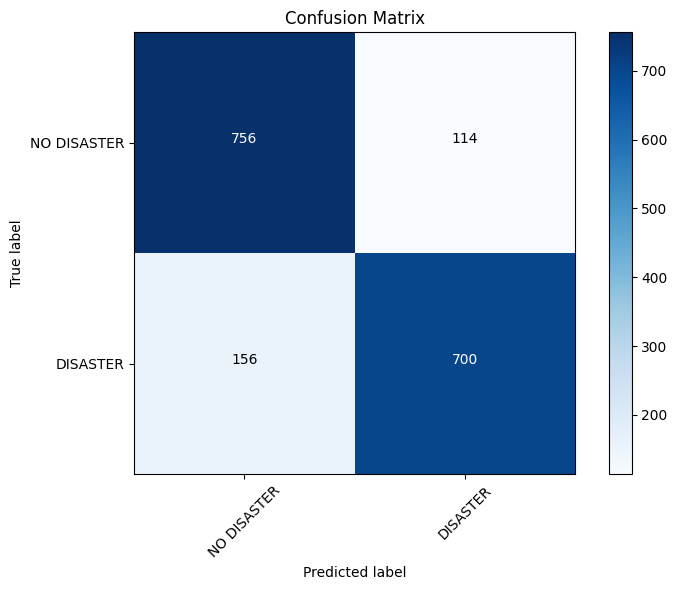

In [37]:
y_true = outputs.label_ids

y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 100:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

In [38]:
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")[['text', 'id']]
df_test['text'] = df_test['text'].apply(clean_text)

df_test.head(5).T

,0,1,2,3,4
text,Just happened a terrible car crash,"Heard about #earthquake is different cities, s...","there is a forest fire at spot pond, geese are...",Apocalypse lighting. #Spokane #wildfires,Typhoon Soudelor kills 28 in China and Taiwan
id,0,2,3,9,11


In [39]:
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

sample_title = '''Engaging Titles Unveiled: Building a Machine Learning Classifier with Google's DistilBERT'''

predictions = pipe(sample_title, top_k=None)
print(predictions)

[{'label': 'NO DISASTER', 'score': 0.9047397971153259}, {'label': 'DISASTER', 'score': 0.09526021033525467}]


In [40]:
label2id = {'NO DISASTER': 0, 'DISASTER': 1}

In [41]:
df_test['target'] = df_test['text'].progress_apply(lambda x: label2id[pipe(x)[0]['label']])

100%|██████████| 3263/3263 [00:20<00:00, 163.07it/s]


In [42]:
df_test.head(20)

,text,id,target
0,Just happened a terrible car crash,0,1
1,"Heard about #earthquake is different cities, s...",2,1
2,"there is a forest fire at spot pond, geese are...",3,1
3,Apocalypse lighting. #Spokane #wildfires,9,1
4,Typhoon Soudelor kills 28 in China and Taiwan,11,1
5,We're shaking...It's an earthquake,12,1
6,They'd probably still show more life than Arse...,21,0
7,Hey! How are you?,22,0
8,What a nice hat?,27,0
9,Fuck off!,29,0


In [43]:
df_test[['id', 'target']].to_csv('submission.csv', index=False)